# Group 14 - Project FP01
## Time series anomaly detection - DAGMM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [119]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [120]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [121]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [122]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [123]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Loading features from file.
Loading features from file.
Loading features from file.
Loading features from file.
--- 0.16459059715270996 seconds ---


In [124]:
def find_collisions_zones(collisions):
    ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
    ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()
    d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
    collision_zones = pd.DataFrame(d)
    return collision_zones

In [125]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [126]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but VarianceThreshold was fitted with feature names

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but VarianceThreshold was fitted with feature names

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but VarianceThreshold was fitted with feature names



In [127]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [128]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [129]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

## DAGMM


In [133]:
from algorithms.dagmm import DAGMM

classifier = DAGMM(
    num_epochs=10,
    lambda_energy=0.1,
    lambda_cov_diag=0.005,
    lr=1e-4,
    batch_size=32,
    gmm_k=5,
    normal_percentile=80,
    sequence_length=30,
    autoencoder_type=DAGMM.AutoEncoder.LSTM,  # Using LSTM autoencoder
    hidden_size=32,
    autoencoder_args={
        'n_layers': (4, 4),
        'use_bias': (True, True),
        'dropout': (0.1, 0.1)
    },
    seed=42,
    gpu=None,  # Set to None for CPU, or specify GPU index if available
    details=True
)

# Train the DAGMM on normal data
classifier.fit(X_train)
print("DAGMM training completed.")


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


DAGMM training completed.


In [134]:
y_test_predict = classifier.predict(X_test)

In [135]:
min(y_test_predict), max(y_test_predict)

(-23.876792214133523, -10.051305449008941)

In [138]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [139]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 13 with threshold -10.588937846381754, std
Number of anomalies detected: 56 with threshold -14.115512895584107, mad
Number of anomalies detected: 16 with threshold -10.684459679325421, percentile
Number of anomalies detected: 0 with threshold -9.097109131018318, IQR

Number of anomalies detected: 15 with threshold -10.306699277883123, std
Number of anomalies detected: 32 with threshold -15.557356902531222, mad
Number of anomalies detected: 9 with threshold -9.001748572985331, percentile
Number of anomalies detected: 28 with threshold -14.308327161714411, IQR

Number of anomalies detected: 5 with threshold -13.011842276438324, std
Number of anomalies detected: 17 with threshold -14.6447734964305, mad
Number of anomalies detected: 8 with threshold -13.428368992275661, percentile
Number of anomalies detected: 0 with threshold -11.911651338849754, IQR



### Anomaly Detection

In [140]:
y_collisions_predict = anomaly_scores > thresholds[1]
y_collisions_predict1 = anomaly_scores1 > thresholds[1]
y_collisions_predict5 = anomaly_scores5 > thresholds[1]

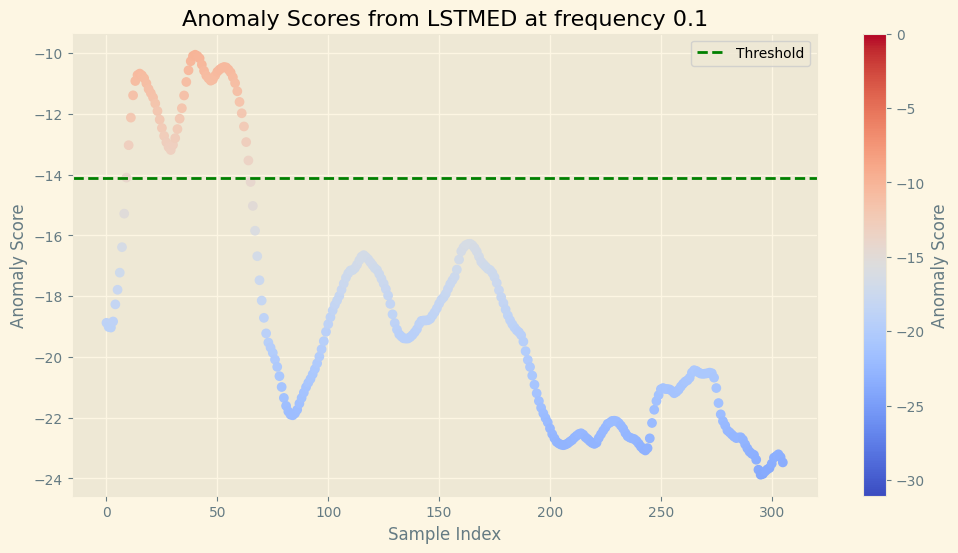

Number of anomalies detected: 56


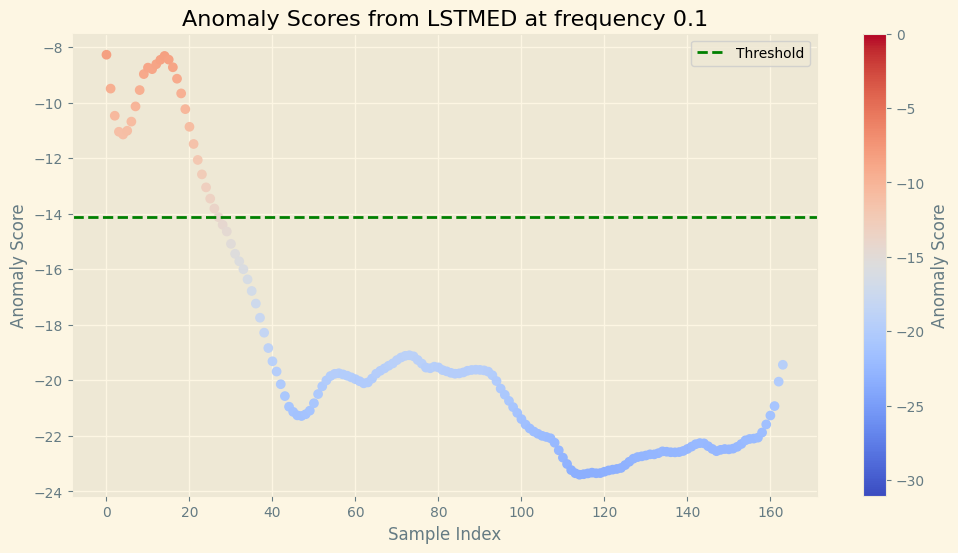

Number of anomalies detected: 27


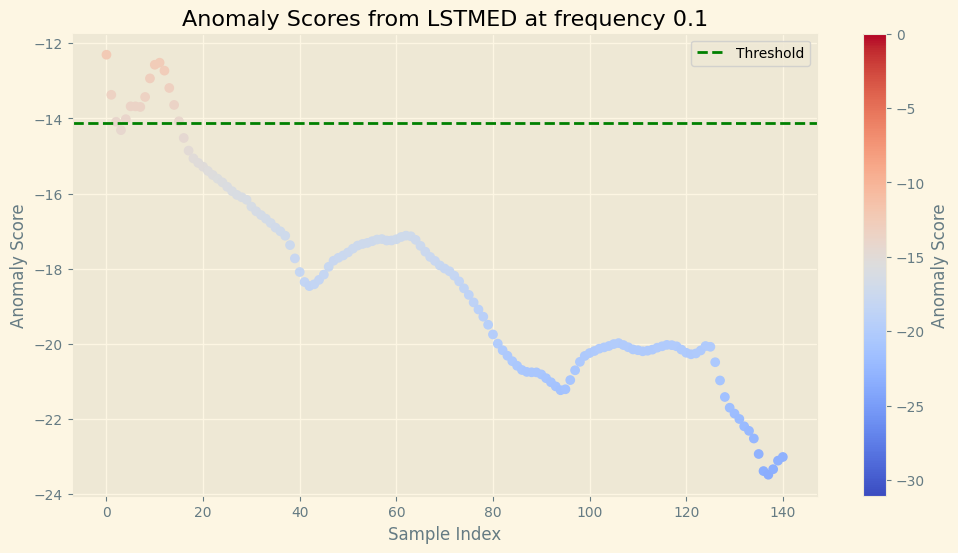

Number of anomalies detected: 15


In [141]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds[1])

In [142]:
X_test_start_end['anomaly_scores'] = anomaly_scores
X_test_start_end['is_collision'] = y_collisions_predict
X_test_start_end1['anomaly_scores'] = anomaly_scores1
X_test_start_end1['is_collision'] = y_collisions_predict1
X_test_start_end5['anomaly_scores'] = anomaly_scores5
X_test_start_end5['is_collision'] = y_collisions_predict5

In [143]:
def compute_metrics(anomaly_scores, y_test, threshold):
    
    print(f"Threshold: {threshold:.4f}")
    
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Calculate F1 score
    f1 = f1_score(y_test, anomaly_scores > threshold)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, anomaly_scores > threshold)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision
    precision = precision_score(y_test, anomaly_scores > threshold)
    print(f"Precision: {precision:.4f}")
    
    # Calculate recall
    recall = recall_score(y_test, anomaly_scores > threshold)
    print(f"Recall: {recall:.4f}")
    
    print(classification_report(y_test, anomaly_scores > threshold))

In [144]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds[1])

Threshold: -14.1155
ROC AUC Score: 0.4875
F1 Score: 0.2484
Accuracy: 0.6046
Precision: 0.3571
Recall: 0.1905
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       201
           1       0.36      0.19      0.25       105

    accuracy                           0.60       306
   macro avg       0.51      0.51      0.49       306
weighted avg       0.56      0.60      0.57       306

############################################
Threshold: -14.1155
ROC AUC Score: 0.5958
F1 Score: 0.3226
Accuracy: 0.7439
Precision: 0.3704
Recall: 0.2857
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       129
           1       0.37      0.29      0.32        35

    accuracy                           0.74       164
   macro avg       0.59      0.58      0.58       164
weighted avg       0.72      0.74      0.73       164

############################################
Threshold: -14.1155
ROC AUC Score: 0.4

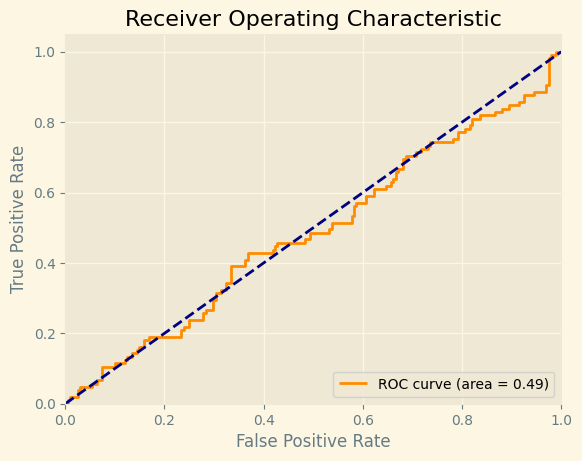

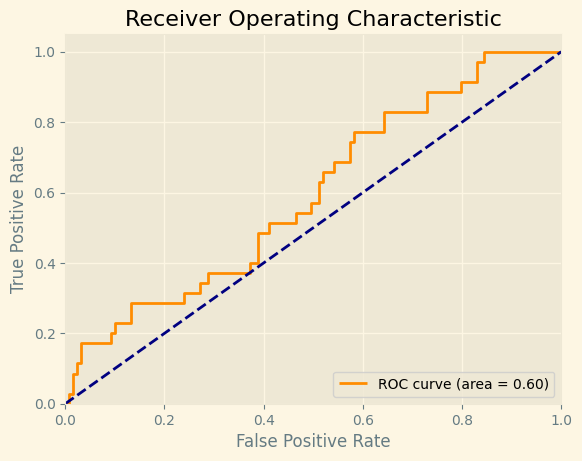

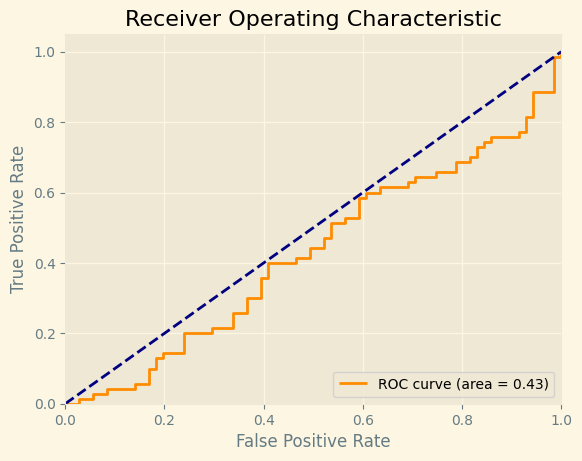

In [145]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [146]:
def convert_to_df(collisions_zones):
    collisions_zones_df = pd.DataFrame(collisions_zones)
    # change the type of the columns to datetime
    collisions_zones_df['start'] = pd.to_datetime(collisions_zones_df['start'])
    collisions_zones_df['end'] = pd.to_datetime(collisions_zones_df['end'])
    
    return collisions_zones_df

In [147]:
collisions_zones_df = convert_to_df(collisions_zones)
collisions_zones_df_1 = convert_to_df(collisions_zones_1)
collisions_zones_df_5 = convert_to_df(collisions_zones_5)

In [148]:
plot_signals(df_collision, df_action_collision, collisions_zones_df, X_test_start_end, title="Normal data with predicted collisions", saveplot=False)

In [149]:
plot_signals(df_collision_1, df_action_collision_1, collisions_zones_df_1, X_test_start_end1, title="Collision 1 data with predicted collisions", saveplot=False)

In [150]:
plot_signals(df_collision_5, df_action_collision_5, collisions_zones_df_5, X_test_start_end5, title="Collision 5 data with predicted collisions", saveplot=False)